# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В проекте представлены данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

**План проекта**

- Разделить исходные данные на обучающую, валидационную и тестовую выборки.
- Исследовать качество разных моделей.
- Проверить качество модели на тестовой выборке.

**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.

- **сalls** — количество звонков,
- **minutes** — суммарная длительность звонков в минутах,
- **messages** — количество sms-сообщений,
- **mb_used** — израсходованный интернет-трафик в Мб,
- **is_ultra** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Импорт библиотек

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
from sklearn.linear_model import LogisticRegression 
import time
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

## Изучение данных 

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В датафрейме нет пропусков. Тип данных не во всех столбцах подобран верно: количество звонков и смс-сообщений должны быть в целочисленном типе данных, is_ultra будет переведено в булев тип. 

В данных информация о 3214 клиентах. 

In [4]:
#изменение типов данных столбцов

df['calls']=df['calls'].astype("int")
df['messages']=df['messages'].astype("int")
df['is_ultra']=df['is_ultra'].astype("bool")

In [5]:
#df.info() #проверка

In [6]:
#проверка на наличие дублтикатов 
df.duplicated().sum()

0

In [7]:
#сводная статистика данных
df.describe()

,calls,minutes,messages,mb_used
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836
std,33.236368,234.569872,36.148326,7570.968246
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500
50%,62.000000,430.600000,30.000000,16943.235000
75%,82.000000,571.927500,57.000000,21424.700000
max,244.000000,1632.060000,224.000000,49745.730000


### Вывод

В датафрейме отсутствуют пропуски и дубликаты. Тип данных в некоторых столбцах был изменен: 
- количество звонков и смс-сообщений переведены в целочисленый тип данных 
- is_ultra переведен в булев тип. 

В данных информация о 3214 клиентах.

## Разделение данных на выборки

Разделение исходных данных на обучающую, валидационную и тестовую выборки

- df_train - обучающая выборка
- df_valid - валидационная выборка 
- df_test - тестовая выборка 

- features - признаки 
- target - целевой признак

In [8]:
# создание переменных для признаков и целевого признака

features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [9]:
# создание тестовой и обучающей выборок

(features_train,
 features_test,
 target_train,
 target_test) = train_test_split(features,target,test_size = 0.25,random_state = 12345)

In [10]:
# вывод размеров таблиц, которые хранятся в четырёх переменных

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(2410, 4)
(2410,)
(804, 4)
(804,)


In [11]:
# деление тестовой выборки на тестовую и валидационную

(features_valid,
 features_test,
 target_valid,
 target_test) = train_test_split(features_test,
                                        target_test,
                                        test_size = 0.5,
                                        random_state = 12345
                                       )

In [12]:
# вывод размеров таблиц, которые хранятся в четырёх переменных

print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(402, 4)
(402,)
(402, 4)
(402,)


## Исследование моделей

Исследование качества разных моделей, при изменении гиперпараметров

### DecisionTree

DecisionTree — это семейство моделей машинного обучения. Решающее дерево предсказывает значение целевой переменной с помощью применения последовательности простых решающих правил

accuracy наилучшей модели на валидационной выборке: 0.8034825870646766
depth наилучшей модели на валидационной выборке: 6
criterion наилучшей модели на валидационной выборке: gini
max_features наилучшей модели на валидационной выборке: auto
Время выполнения ячейки: 1.62 c


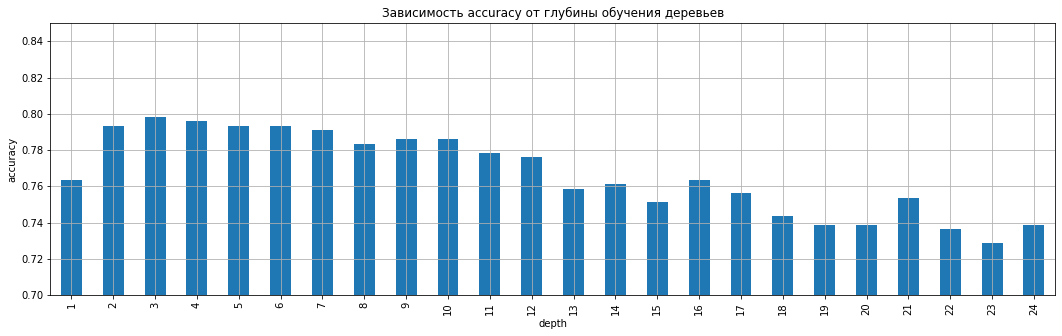

In [13]:
start_time = time.perf_counter()
counter=0
dt_depth={}
dt_best = None
dt_best_accuracy = 0
dt_best_depth = 0
dt_best_criterion = 0
dt_max_features = 0
frame = pd.DataFrame(columns=['criterion','depth','max_features','accuracy'])
for criterion in ['gini', 'entropy']:
    for depth in range(1,25):
        for f in ['auto', 'sqrt', 'log2',  None]:
            dt_model = DecisionTreeClassifier(criterion = criterion, 
                                              random_state = 12345, 
                                              max_depth = depth,
                                              max_features = f)
            dt_model.fit(features_train,target_train)
            dt_prediction_valid = dt_model.predict(features_valid)
            dt_accuracy = accuracy_score(dt_prediction_valid, target_valid)
            
            dt_depth[depth] = dt_accuracy
            
            if dt_best_accuracy < dt_accuracy:
                            dt_best = dt_model
                            dt_best_accuracy = dt_accuracy
                            dt_best_depth = depth
                            dt_best_criterion = criterion
                            dt_max_features = f
                            
                            frame.loc[counter]=[criterion,depth,f,dt_accuracy]
                            counter += 1
                                                       
print("accuracy наилучшей модели на валидационной выборке:", dt_best_accuracy)
print("depth наилучшей модели на валидационной выборке:", dt_best_depth)
print("criterion наилучшей модели на валидационной выборке:", dt_best_criterion)
print("max_features наилучшей модели на валидационной выборке:", dt_max_features)

pd.Series(dt_depth).plot.bar(title='Зависимость accuracy от глубины обучения деревьев', ylim=(.7,.85),figsize=(18,5))
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.grid()
dt_time = round((time.perf_counter() - start_time),3)
print("Время выполнения ячейки:", dt_time,'c')

In [14]:
frame.sort_values(by='accuracy', ascending=False).head()

,criterion,depth,max_features,accuracy
4,gini,6,auto,0.803483
3,gini,3,auto,0.798507
2,gini,2,None,0.793532
1,gini,1,None,0.763682
0,gini,1,auto,0.756219


Несмотря на то, что согласно графику при глубине выше 3 наступает перобучение и качество модели падает, при переборе параметра max_features accuracy максимальна при max_depth=6

Создам еще одно дерево решений с лучшими параметрами по метрике accuracy для того, чтобы сохранить время выполнения кода для последующего анализа всех исследуемых моделей машинного обучения

In [15]:
start_time = time.perf_counter()
dt_model_end = DecisionTreeClassifier(random_state = 12345, 
                                              max_depth = 6,
                                              max_features = 'auto')
dt_model_end.fit(features_train,target_train)
dt_prediction_valid = dt_model_end.predict(features_valid)
dt_accuracy = accuracy_score(dt_prediction_valid, target_valid)
print("accuracy", dt_accuracy)
dt_time = round((time.perf_counter() - start_time),3)           
print("Время выполнения ячейки:", dt_time,'c')

accuracy 0.8034825870646766
Время выполнения ячейки: 0.007 c


### RandomForest

Алгоритм обучает большое количество независимых друг от друга
деревьев, а потом принимает решение на основе голосования

**Длительность кода 5 минут**

Accuracy наилучшей модели на валидационной выборке: 0.8233830845771144
est наилучшей модели на валидационной выборке: 9
depth наилучшей модели на валидационной выборке: 11
criterion наилучшей модели на валидационной выборке: gini
max_features наилучшей модели на валидационной выборке: auto
Время выполнения ячейки: 299.147 c


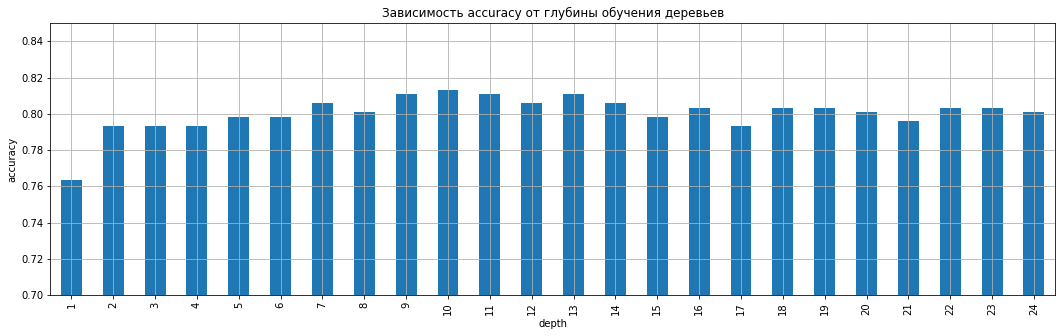

In [16]:
start_time = time.perf_counter()
rf_estim = {}
rf_depth = {}
rf_best = None
rf_best_accuracy = 0
rf_best_est = 0
rf_best_depth = 0
dt_best_criterion = 0
dt_max_features = 0
counter=0
frame = pd.DataFrame(columns=['criterion', 'n_estimator','depth','max_features','accuracy'])
for criterion in ['gini', 'entropy']:
    for est in range(1,25):
        for depth in range(1,25):
            for f in ['auto', 'sqrt', 'log2',  None]:
                rf_model = RandomForestClassifier(criterion = criterion,
                                              random_state = 12345,
                                              n_estimators = est,
                                              max_depth = depth,
                                              max_features=f)
                rf_model.fit(features_train,target_train)
                rf_prediction_valid = rf_model.predict(features_valid)
                rf_accuracy = accuracy_score(rf_prediction_valid, target_valid)
                
                rf_depth[depth] = rf_accuracy
                score = rf_model.score(features_valid, target_valid)
                rf_estim[est] = score 
                
                if rf_best_accuracy < rf_accuracy:
                    rf_best = rf_model
                    rf_best_depth = depth
                    rf_best_est = est
                    rf_best_accuracy = rf_accuracy
                    rf_best_criterion = criterion
                    rf_max_features = f
            
                frame.loc[counter]=[criterion,est,depth,f,rf_accuracy]
                counter += 1
print("Accuracy наилучшей модели на валидационной выборке:", rf_best_accuracy)
print("est наилучшей модели на валидационной выборке:", rf_best_est)
print("depth наилучшей модели на валидационной выборке:", rf_best_depth)
print("criterion наилучшей модели на валидационной выборке:", rf_best_criterion)
print("max_features наилучшей модели на валидационной выборке:", rf_max_features)

pd.Series(rf_depth).plot.bar(title='Зависимость accuracy от глубины обучения деревьев', ylim=(.7,.85),figsize=(18,5))
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.grid()

rf_time = round((time.perf_counter() - start_time),3)
print("Время выполнения ячейки:", rf_time,'c')

Согласно графику лучшее качество модели достигается при глубине обучения в пределах значений 9-13

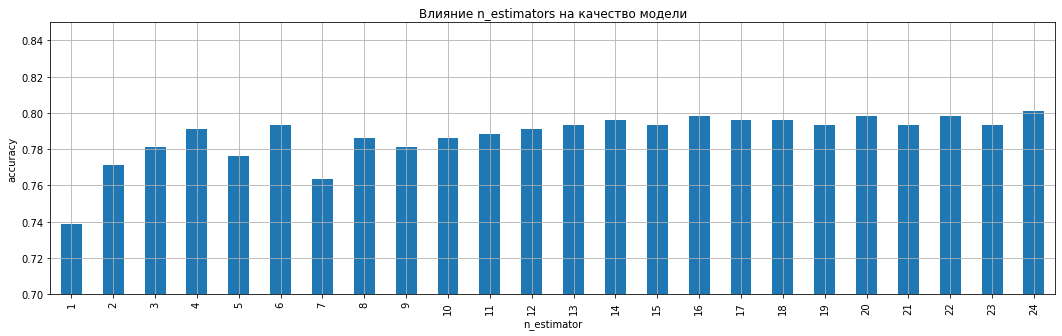

In [17]:
pd.Series(rf_estim).plot.bar(title='Влияние n_estimators на качество модели', ylim=(.7,.85),figsize=(18,5))
plt.xlabel('n_estimator')
plt.ylabel('accuracy')
plt.grid()


In [18]:
frame.sort_values(by='accuracy', ascending=False).head()

,criterion,n_estimator,depth,max_features,accuracy
809,gini,9,11,sqrt,0.823383
810,gini,9,11,log2,0.823383
808,gini,9,11,auto,0.823383
3595,entropy,14,11,None,0.823383
3787,entropy,16,11,None,0.818408


Согласно графику влияния n_estimators максимальное accuracy достигается при количестве деревьев = 24, но при переборе 4 гипермараметров получается, что для наилучшее качество модели достигается при использование критерия gini, количества деревьев 9, с глубиной деревьев 9 и max_features {'auto', 'sqrt', 'log2'}

Создам еще одно дерево решений с лучшими параметрами по метрике accuracy для того, чтобы сохранить время выполнения кода для последующего анализа всех исследуемых моделей машинного обучения

In [19]:
start_time = time.perf_counter()
rf_model = RandomForestClassifier(random_state = 12345,
                                              n_estimators = 9,
                                              max_depth = 11,
                                              max_features='sqrt')
rf_model.fit(features_train,target_train)
rf_prediction_valid = rf_model.predict(features_valid)
rf_accuracy = accuracy_score(rf_prediction_valid, target_valid)
print("accuracy", rf_accuracy)
rf_time = round((time.perf_counter() - start_time),3)
print("Время выполнения ячейки:", rf_time,'c')

accuracy 0.8233830845771144
Время выполнения ячейки: 0.04 c


### LogisticRegression

Логистическая регрессия:
- сначала считает, к какому классу близок объект
- в зависимости от ответа выбирает нужный класс: если результат
вычисления положительный, то — «1»; отрицательный — «0»

In [20]:
start_time = time.perf_counter()

lr_best = None
lr_best_accuracy = 0
lr_best_multi_class = 0
lr_best_solver = 0
lr_max_iter = 0
counter=0

frame = pd.DataFrame(columns=['penalty','multi_class','solver','accuracy'])
for penalty in ['l2', 'none']:
    for multi_class in ['auto', 'ovr', 'multinomial']:
        for solver in ['lbfgs', 'sag', 'saga']:
            lr_model = LogisticRegression(penalty = penalty,
                                              multi_class = multi_class,
                                              random_state = 12345,
                                              max_iter = 10000, 
                                              solver = solver)
            lr_model.fit(features_train,target_train)
            lr_prediction_valid = lr_model.predict(features_valid)
            lr_accuracy = accuracy_score(lr_prediction_valid, target_valid)
                
            if lr_best_accuracy < lr_accuracy:
                lr_best = lr_model
                lr_best_multi_class = multi_class
                lr_best_accuracy = lr_accuracy
                lr_best_solver = solver
            
            frame.loc[counter]=[penalty, multi_class, solver, lr_accuracy]
            counter += 1
                
print("Accuracy наилучшей модели на валидационной выборке:", lr_best_accuracy)
lr_time = round((time.perf_counter() - start_time),3)
print("Время выполнения ячейки:", lr_time,'c')

Accuracy наилучшей модели на валидационной выборке: 0.7039800995024875
Время выполнения ячейки: 10.801 c


In [21]:
frame.sort_values(by='accuracy', ascending=False).head(7)

,penalty,multi_class,solver,accuracy
0,l2,auto,lbfgs,0.703980
6,l2,multinomial,lbfgs,0.703980
15,none,multinomial,lbfgs,0.703980
12,none,ovr,lbfgs,0.703980
9,none,auto,lbfgs,0.703980
3,l2,ovr,lbfgs,0.703980
5,l2,ovr,saga,0.701493


При переборе 4 гипермараметров получаем, что максимальное accuracy достигается при дефолтных параметрах 

Создам еще одно дерево решений с лучшими параметрами по метрике accuracy для того, чтобы сохранить время выполнения кода для последующего анализа всех исследуемых моделей машинного обучения

In [22]:
start_time = time.perf_counter()
lr_model = LogisticRegression(random_state = 12345,
                              max_iter = 10000)
lr_model.fit(features_train,target_train)
lr_prediction_valid = lr_model.predict(features_valid)
lr_accuracy = accuracy_score(lr_prediction_valid, target_valid)
            
                     
print("accuracy", lr_accuracy)
lr_time = round((time.perf_counter() - start_time),3)
print("Время выполнения ячейки:", lr_time,'c')

accuracy 0.7039800995024875
Время выполнения ячейки: 0.141 c


### Вывод

Анализ трех методов машинного обучения

In [23]:
#таблица основных показателей
recap = {'accuracy':[dt_best_accuracy, rf_best_accuracy, lr_accuracy], 'speed':[dt_time, rf_time, lr_time]} 
 
recap = pd.DataFrame(recap, index =['Decision Tree', 'Random Forest', 'Logistic Regression'])  
recap

,accuracy,speed
Decision Tree,0.803483,0.007
Random Forest,0.823383,0.040
Logistic Regression,0.703980,0.141


Самое высокое качество модели Random Forest 0.82.
Decision Tree имеет среднее качество модели 0.80 и самую высокую скорость выполнения

## Проверка модели на тестовой выборке

- **Предсказывание моделей на тестовой выборке**

In [24]:
#DecisionTree
dt_prediction_test = dt_best.predict(features_test)

#RandomForest
rf_prediction_test = rf_best.predict(features_test)

#LogisticRegression
lr_prediction_test = lr_model.predict(features_test)

- **Качество предсказываний моделей на тестовой выборке**

In [25]:
#DecisionTree
dt_accuracy_test = accuracy_score(dt_prediction_test, target_test)

#RandomForest
rf_accuracy_test = accuracy_score(rf_prediction_test, target_test)

#LogisticRegression
lr_accuracy_test = accuracy_score(lr_prediction_test, target_test)

In [26]:
print("Accuracy тестовой выборки DecisionTree:", dt_accuracy_test)
print("Accuracy тестовой выборки RandomForest:", rf_accuracy_test)
print("Accuracy тестовой выборки LogisticRegression:", lr_accuracy_test)

Accuracy тестовой выборки DecisionTree: 0.7910447761194029
Accuracy тестовой выборки RandomForest: 0.7910447761194029
Accuracy тестовой выборки LogisticRegression: 0.7039800995024875


In [27]:
accuracy_test = [dt_accuracy_test, rf_accuracy_test, lr_accuracy_test]
recap['accuracy_test'] = accuracy_test

### Вывод проверки моделей на тестовой выборке

Самое высокое качество на тестовой выборке показала модель Random Forest 0.79

## Общий вывод

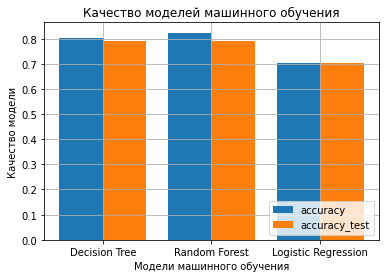

In [28]:
fig = plt.figure(figsize = (6, 4))  
X = recap.index
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, recap['accuracy'], 0.4, label = 'accuracy')
plt.bar(X_axis + 0.2, recap['accuracy_test'], 0.4, label = 'accuracy_test')

plt.xticks(X_axis, X)
plt.xlabel("Модели машинного обучения")
plt.ylabel("Качество модели")
plt.title("Качество моделей машинного обучения")
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [29]:
recap

,accuracy,speed,accuracy_test
Decision Tree,0.803483,0.007,0.791045
Random Forest,0.823383,0.040,0.791045
Logistic Regression,0.703980,0.141,0.703980


**1. Анализ данных:**

В датафрейме отсутствуют пропуски и дубликаты. Тип данных в некоторых столбцах был изменен:

- количество звонков и смс-сообщений переведены в целочисленый тип данных
- is_ultra переведен в булев тип.

В данных информация о 3214 клиентах.

**2. Разделение данных:** 

- Произведено разделение исходных данных на обучающую, валидационную и тестовую выборки

**3. Исследование моделей машинного обучение:**

- Произведено исследование качества разных моделей при изменении гиперпараметров. Использовались модели машинного обучения: Decision Tree, Random Forest, Logistic Regression.
- Было определенно, что высокое качество имеет модель Random Forest (0.82). Decision Tree имеет среднее качество модели (0.80) и самую быструю скорость выполнения. Logistic Regression имеет минимальное качество модели и максимальную скорость выполнения.

**4. Проверка модели на тестовой выборке:**

- Произведена проверка моделей на тестовой выборке. Одинаковое высокое качество имели модели Decision Tree и Random Forest (0.79). Decision Tree при этом имеет более высокую скорость выполнения

**Лучшая модель для выбора подходящего тарифа по качеству предсказания является Random Forest. На валидационной выборке имеет самое высокое показаниу качества - 0.82. На тестовой выборке одинаковые показания качества у Random Forest и Decision Tree - 0.79. 
Но данная модель имеет среднюю скорость выполнения.
Если скорость выполнения модели имеет значение, то необходимо выбрать модель Decision Tree со средними показаниями на валидационной и тестовой выборке - 0.80 и 0,79 и с высокой скоростью выполнения**